In [1]:
from models_and_trainers.copy_gen_transformer import CopyGeneratorTransformer

import numpy as np
import time
import math
import torch
import torch.nn as nn
import torchtext
from torchtext.data import Field, BucketIterator

from utils.useful_utils import string_split_v3, string_split_v2, string_split_v1
from utils.metrics import nltk_bleu
from utils.dataset_loaders import SRC_TGT_pairs
import utils.beam_search as beam_search
import tqdm.notebook as tqdm 

from models_and_trainers.trainers import Model_Trainer
from utils.data2dataset_fns import data2dataset_shared_vocab_with_OOVs, CustomEncode, BERTEncode
from utils.evaluate_fns import evaluate, batch_to_output_autorregressive, create_eval_fn

from utils.vocab_classes import Shared_Vocab, BERT_Vocab
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == "cuda":
    torch.cuda.set_device(0) # choose GPU from nvidia-smi 
print("Using:", device)

Using: cuda


In [3]:
src_train_fp = "datasets/CoNaLa/conala-train.src"
tgt_train_fp = "datasets/CoNaLa/conala-train.tgt"
src_test_fp = "datasets/CoNaLa/conala-test.src"
tgt_test_fp = "datasets/CoNaLa/conala-test.tgt"

max_seq_len = 100

train_samples = SRC_TGT_pairs(src_train_fp, tgt_train_fp, max_seq_len=max_seq_len).samples
test_samples = SRC_TGT_pairs(src_test_fp, tgt_test_fp, max_seq_len=max_seq_len).samples

In [4]:
vocab = BERT_Vocab()

In [5]:
encode_fn = BERTEncode(vocab)

In [6]:
train_dataset = data2dataset_shared_vocab_with_OOVs(train_samples, encode_fn, vocab)
test_dataset = data2dataset_shared_vocab_with_OOVs(test_samples, encode_fn, vocab)

In [7]:
batch_size = 32

train_iterator = BucketIterator(
    train_dataset,
    batch_size = batch_size,
    repeat=True,
    shuffle=True,
    sort=True,
    sort_key = lambda x: len(x.src)+len(x.tgt),
    device = device)

test_iterator = BucketIterator(
    test_dataset,
    batch_size = batch_size,
    sort=True,
    sort_key = lambda x: len(x.src)+len(x.tgt),
    device = device)

In [8]:
sample = next(iter(train_dataset))
vocab.decode_input(sample.tgt, [])

'sum ( d * 10 * * i for i , d in en ##ume ##rate ( x [ : : - 1 ] ) )'

In [9]:
for i, batch in enumerate(train_iterator):
    for idx in range(batch_size):
        encoder_input = batch.src.cpu()[:,idx].tolist()
        decoder_input = batch.tgt.cpu()[:,idx].tolist()
        OOVs = batch.OOVs.cpu()[:,idx].tolist()

        print("encoder_input    :",vocab.decode_input(encoder_input, OOVs))
        print("decoder_input    :",vocab.decode_output(decoder_input, OOVs))
        print()
        break
    break

encoder_input    : [unused0] make a 60 seconds time delay [unused1] [PAD]
decoder_input    : [unused0] time . sleep ( 60 ) [unused1] [PAD] [PAD]



In [10]:
model = CopyGeneratorTransformer(embed_dim=512, att_heads=8, layers=4, dim_feedforward=1024, max_seq_length=max_seq_len).to(device)

In [11]:
criterion = nn.CrossEntropyLoss(ignore_index=vocab.PAD)
params = model.parameters()

def train_step(batch):
    total_loss = 0.
    start_time = time.time()
    encoder_input = batch.src
    decoder_input = batch.tgt[:-1]
    targets = batch.tgt[1:]

    optimizer.zero_grad()
    output = model(encoder_input, decoder_input)

    loss = criterion(output.view(-1, vocab.vocab_size), targets.view(-1))
    loss.backward()
    torch.nn.utils.clip_grad_norm_(params, 0.5)
    optimizer.step()
    elapsed = time.time() - start_time
    return loss

In [12]:
lr = 0.005 # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.99)

trainer = Model_Trainer(optimizer, scheduler)

In [14]:
eval_fn = create_eval_fn(model, 
                         test_iterator, 
                         batch_to_output_autorregressive, 
                         vocab, 
                         out_file="small_transformer_BERT_tokenizer_CoNaLa.out", 
                         max_seq_len=100)

In [16]:
scores = trainer.train(model,train_iterator,train_step,500000,eval_fn=eval_fn, eval_interval=10000)

Evaluating model



| EVALUATION | BLEU: 0.096 |
Evaluating model



| EVALUATION | BLEU: 0.142 |
Evaluating model



| EVALUATION | BLEU: 0.152 |
Evaluating model



| EVALUATION | BLEU: 0.156 |
Evaluating model



| EVALUATION | BLEU: 0.176 |
Evaluating model



| EVALUATION | BLEU: 0.188 |
Evaluating model



| EVALUATION | BLEU: 0.185 |
Evaluating model



| EVALUATION | BLEU: 0.185 |
Evaluating model



| EVALUATION | BLEU: 0.193 |
Evaluating model



| EVALUATION | BLEU: 0.188 |
Evaluating model



| EVALUATION | BLEU: 0.185 |
Evaluating model



| EVALUATION | BLEU: 0.183 |
Evaluating model



| EVALUATION | BLEU: 0.185 |
Evaluating model



| EVALUATION | BLEU: 0.193 |
Evaluating model



| EVALUATION | BLEU: 0.188 |
Evaluating model



| EVALUATION | BLEU: 0.190 |
Evaluating model



| EVALUATION | BLEU: 0.183 |
Evaluating model



| EVALUATION | BLEU: 0.189 |
Evaluating model



| EVALUATION | BLEU: 0.191 |
Evaluating model



| EVALUATION | BLEU: 0.184 |
Evaluating model



| EVALUATION | BLEU: 0.186 |
Evaluating model



| EVALUATION | BLEU: 0.185 |
Evaluating model



| EVALUATION | BLEU: 0.189 |
Evaluating model



| EVALUATION | BLEU: 0.190 |
Evaluating model



| EVALUATION | BLEU: 0.183 |
Keyboard Interrupt!


In [18]:
evaluate(model, test_iterator, batch_to_output_autorregressive, vocab, out_file="small_transformer_BERT_tokenizer_CoNaLa.out", max_seq_len=100)


| EVALUATION | BLEU: 0.180 |


0.18003576003198324

In [19]:
eval_fn()


| EVALUATION | BLEU: 0.180 |


0.18003576003198324

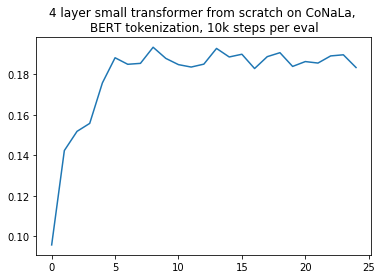

In [21]:
import matplotlib.pyplot as plt
plt.plot(scores)
plt.title("4 layer small transformer from scratch on CoNaLa, \nBERT tokenization, 10k steps per eval")
plt.show()

In [58]:
[0.12180583,
 0.16160583,
 0.19913348,
 0.3275674,
 0.4185002,
 0.4560558,
 0.468155,
 0.4760713,
 0.49842156,
 0.5062607,
 0.537111,
 0.5415668,
 0.5394673,
 0.5603253,
 0.5723121,
 0.5840252,
 0.5825944,
 0.5848066,
 0.5875926,
 0.6015225,
 0.5865923,
 0.6188454,
 0.6046905,
 0.6226139,
 0.6224076,
 0.6208651,
 0.6342907,
 0.6349491,
 0.6343567,
 0.6325313,
 0.6441005,
 0.6349922,
 0.6471391,
 0.6558979,
 0.6398276,
 0.6379132,
 0.6560823,
 0.6378102,
 0.6528486,
 0.6678966,
 0.6611502,
 0.6610722,
 0.6554508,
 0.6559057,
 0.660657,
 0.6735468,
 0.6668088,
 0.6737474,
 0.6678763,
 0.6754331,
 0.669048,
 0.6712507,
 0.6751137,
 0.6853862,
 0.6706823,
 0.6722339,
 0.6754824,
 0.6808967,
 0.6815051,
 0.6789486,
 0.6758819,
 0.6775829,
 0.6802866,
 0.6810562,
 0.6814699,
 0.6770886,
 0.6782239,
 0.6805622,
 0.6842751,
 0.6823802,
 0.6798837,
 0.6762986,
 0.67734,
 0.684747,
 0.6769588,
 0.6807317,
 0.6821235,
 0.6966815,
 0.6898928,
 0.6940053,
 0.679528,
 0.6892099,
 0.6718987,
 0.6780844,
 0.6855779,
 0.6836823,
 0.67685,
 0.6802615,
 0.6920519,
 0.6856342,
 0.6937595,
 0.6858136,
 0.6946514,
 0.6950252,
 0.6800106,
 0.6744613,
 0.691399,
 0.6926426,
 0.6958578,
 0.6977212,
 0.6900218,
 0.6856229,
 0.691839,
 0.6962903,
 0.6936583]

[0.12189497651120583,
 0.16164382049810583,
 0.19916312269773348,
 0.3275679586537674,
 0.4185609025169002,
 0.4560380848256558,
 0.468132137640055,
 0.4760777393032713,
 0.49848235463022156,
 0.5062434648007607,
 0.537119487378111,
 0.5415516251436668,
 0.5394365487661673,
 0.5603091683851253,
 0.5723141458093121,
 0.5840777264451252,
 0.5825225306143944,
 0.5848905875785066,
 0.5875649567913926,
 0.6015076712290225,
 0.5865396971798923,
 0.6188437291719454,
 0.6046434237945905,
 0.6226226983188139,
 0.6224113138810076,
 0.6208680726302651,
 0.6342416698927907,
 0.6349380773503491,
 0.6343420143620567,
 0.6325407361705313,
 0.6441319543341005,
 0.6349255666047922,
 0.6471959466818391,
 0.6558042464920979,
 0.6398247148548276,
 0.6379952814404132,
 0.6560204413950823,
 0.6378531162715102,
 0.6528098299021486,
 0.6678708806300966,
 0.6611406607210502,
 0.6610034111756722,
 0.6554407852509508,
 0.6559579512891057,
 0.660632455011257,
 0.6735112380816468,
 0.6668364026129088,
 0.673718165